# FEMM Modeling via pyFEMM

## Setup

In [2]:
# !pip install pyfemm

In [58]:
import femm
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
# The package must be initialized with the openfemm command.
femm.openfemm();  

In [22]:
# We need to create a new Magnetostatics document to work on.
femm.newdocument(0);

## Magnetics Pre Processing - 'mi'

In [23]:
# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-8) for the linear solver; a placeholder of 0 for 
# the depth dimension, and an angle constraint of 30 degrees
femm.mi_probdef(0, 'millimeters', 'axi', 1.e-8, 0, 30);

# Draw a rectangle for the steel bar on the axis;
femm.mi_drawrectangle(0, -40, 10, 40);

# Draw a rectangle for the coil;
femm.mi_drawrectangle(50, -50, 100, 50);

# Define an "open" boundary condition using the built-in function:
femm.mi_makeABC()

# Add block labels, one to each the steel, coil, and air regions.
femm.mi_addblocklabel(5,0);
femm.mi_addblocklabel(75,0);
femm.mi_addblocklabel(30,100);

# Add some block labels materials properties
femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('Coil', 1, 1, 0, 0, 58*0.65, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('LinearIron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);

# A more interesting material to add is the iron with a nonlinear
# BH curve.  First, we create a material in the same way as if we 
# were creating a linear material, except the values used for 
# permeability are merely placeholders.

femm.mi_addmaterial('Iron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);

In [24]:
# A set of points defining the BH curve is then specified.
bdata = [ 0.,0.3,0.8,1.12,1.32,1.46,1.54,1.62,1.74,1.87,1.99,2.046,2.08]; 
hdata = [ 0, 40, 80, 160, 318, 796, 1590, 3380, 7960, 15900, 31800, 55100, 79600];
for n in range(0,len(bdata)):
	femm.mi_addbhpoint('Iron', bdata[n],hdata[n]);

In [25]:
# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop('icoil', 20, 1);

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(5,0);
femm.mi_setblockprop('Iron', 0, 1, '<None>', 0, 0, 0);
femm.mi_clearselected()

femm.mi_selectlabel(75,0);
femm.mi_setblockprop('Coil', 0, 1, 'icoil', 0, 0, 200);
femm.mi_clearselected()

femm.mi_selectlabel(30,100);
femm.mi_setblockprop('Air', 0, 1, '<None>', 0, 0, 0);
femm.mi_clearselected()

# Now, the finished input geometry can be displayed.
femm.mi_zoomnatural()

In [26]:
# We have to give the geometry a name before we can analyze it.
femm.mi_saveas('coil.fem');

In [27]:
# Now,analyze the problem and load the solution when the analysis is finished
femm.mi_analyze()
femm.mi_loadsolution()

In [82]:
## Save as Image  
# femm.mi_zoomnatural()
femm.mi_zoom(0,0,200,200)  # x1, y1, x2, y2

In [83]:
femm.mi_savebitmap('Output_PreProcessing.bmp') # ("filename")  
# femm.mi_savemetafile('Output_Meta')  

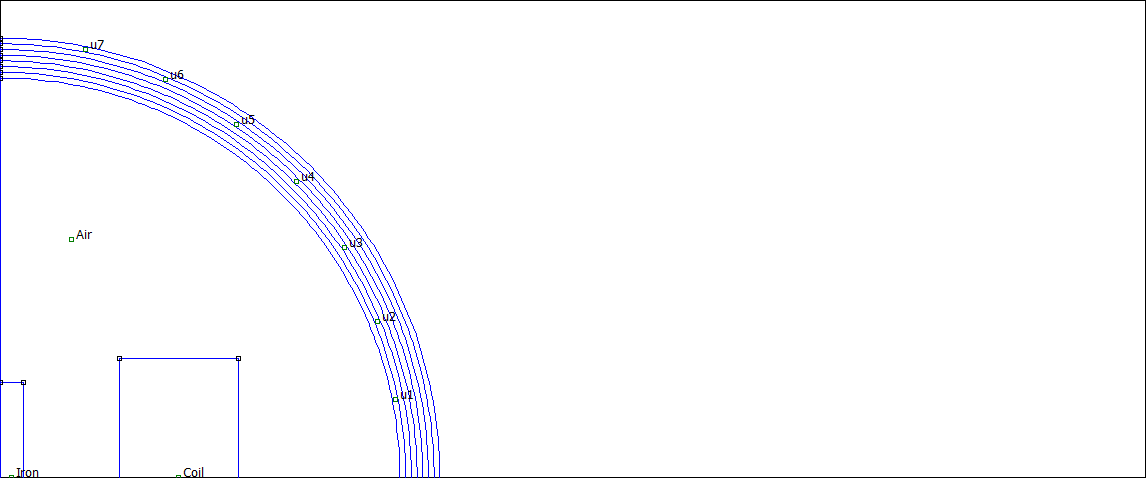

In [84]:
Image.open('Output_PreProcessing.bmp')

## Magnetics Post Processing - 'mo'

In [85]:
femm.mo_showdensityplot(1, 0, 0.000197118052262532, 0.516967928277248, 'bmag') # legend, gscale, upper_B, lower_B, type; pyFEMM Manual pg.21

In [86]:
## Zoom Post Processing
# femm.mo_zoomnatural()
femm.mo_zoom(0,0,200,200) # x1, y1, x2, y2

In [87]:
## Save Image of Port Processing
femm.mo_savebitmap('Output_Post_Processing.bmp')

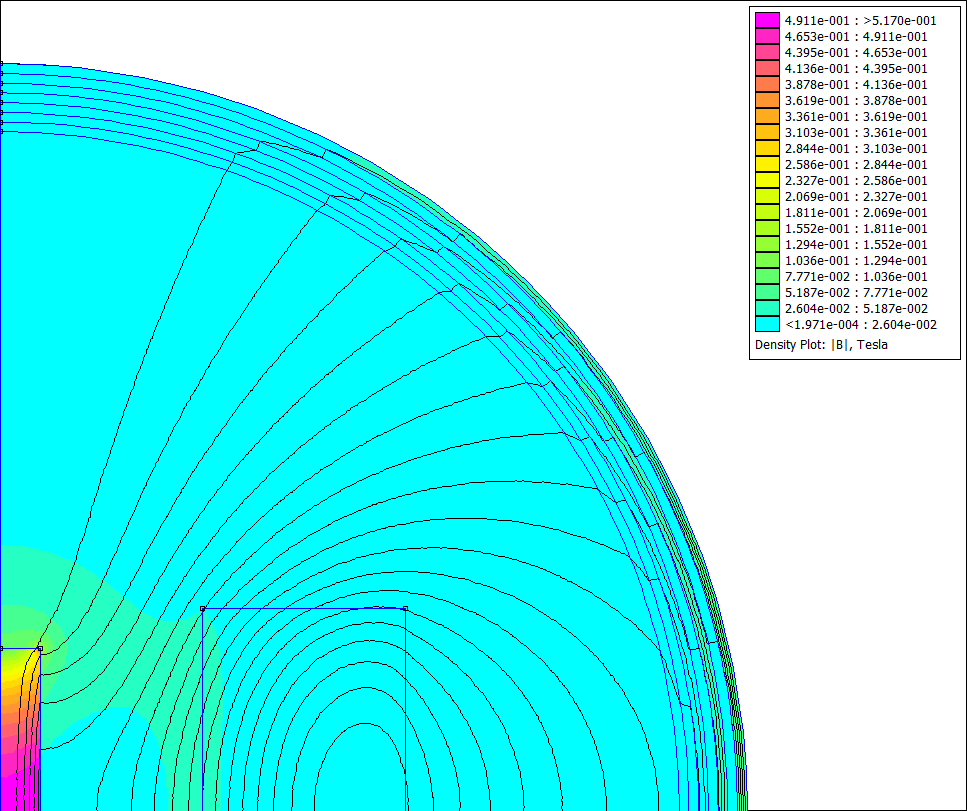

In [88]:
Image.open('Output_Post_Processing.bmp')

### Graphing Analysis

In [12]:
# If we were interested in the flux density at specific positions, 
# we could inquire at specific points directly:
b0=femm.mo_getb(0,0);
print('Flux density at the center of the bar is %g T' % b0[1]);
b1=femm.mo_getb(0,50);
print('Flux density at r=0,z=50 is %g T' % b1[1]);

# The program will report the terminal properties of the circuit:
# current, voltage, and flux linkage 
vals = femm.mo_getcircuitproperties('icoil');

# [i, v, \[Phi]] = MOGetCircuitProperties["icoil"]

# If we were interested in inductance, it could be obtained by
# dividing flux linkage by current
L = 1000*vals[2]/vals[0];
print('The self-inductance of the coil is %g mH' % L);

Flux density at the center of the bar is 0.504432 T
Flux density at r=0,z=50 is 0.053487 T
The self-inductance of the coil is 4.37673 mH


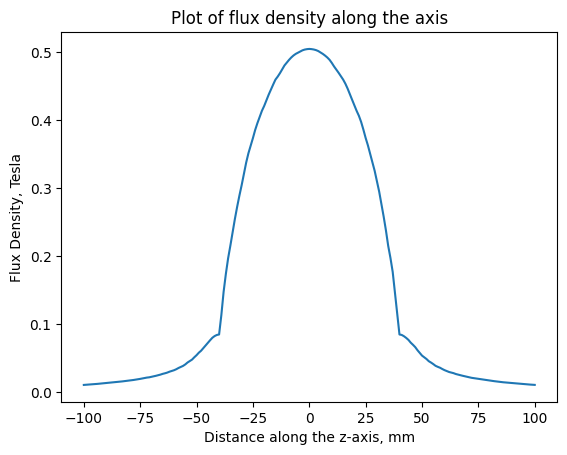

In [13]:
# Or we could, for example, plot the results along a line using 
zee=[]
bee=[]
for n in range(-100,101):
	b=femm.mo_getb(0,n);
	zee.append(n)
	bee.append(b[1]);

plt.plot(zee,bee)
plt.ylabel('Flux Density, Tesla')
plt.xlabel('Distance along the z-axis, mm')
plt.title('Plot of flux density along the axis')
plt.show()

## ShutDown 

In [14]:
# When the analysis is completed, FEMM can be shut down.
femm.closefemm();